In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-0'

# SSRT by SSD

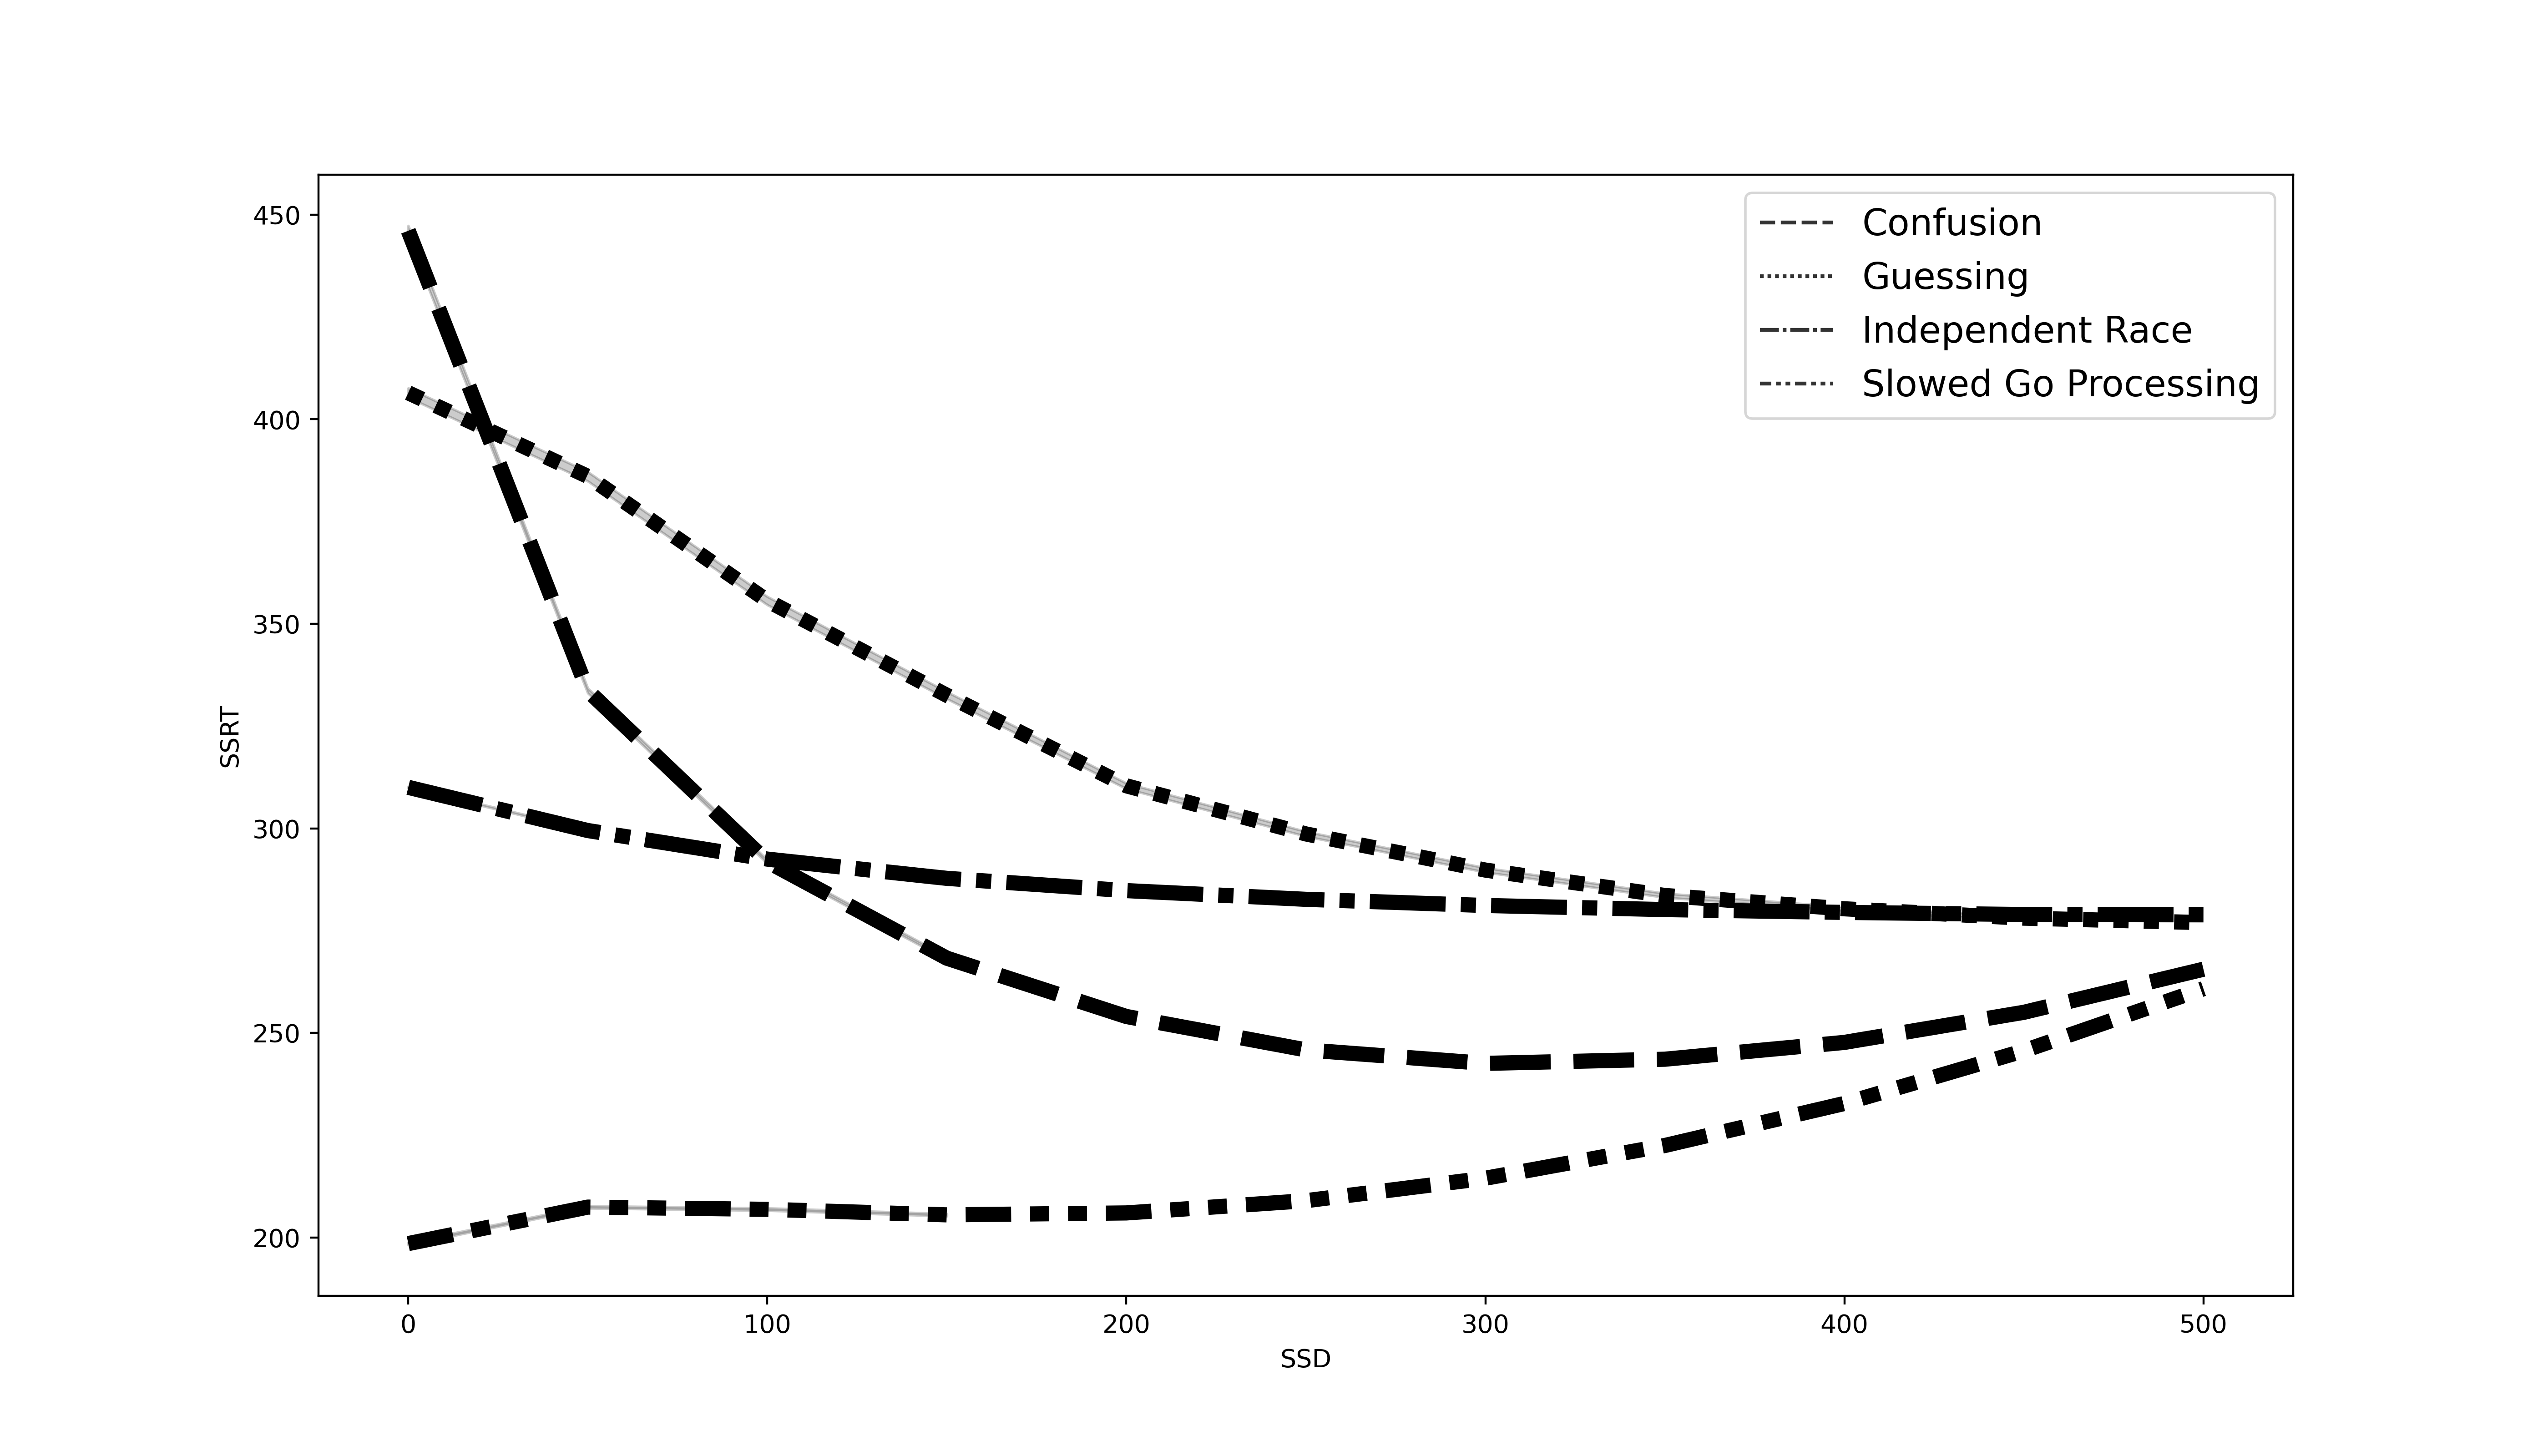

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

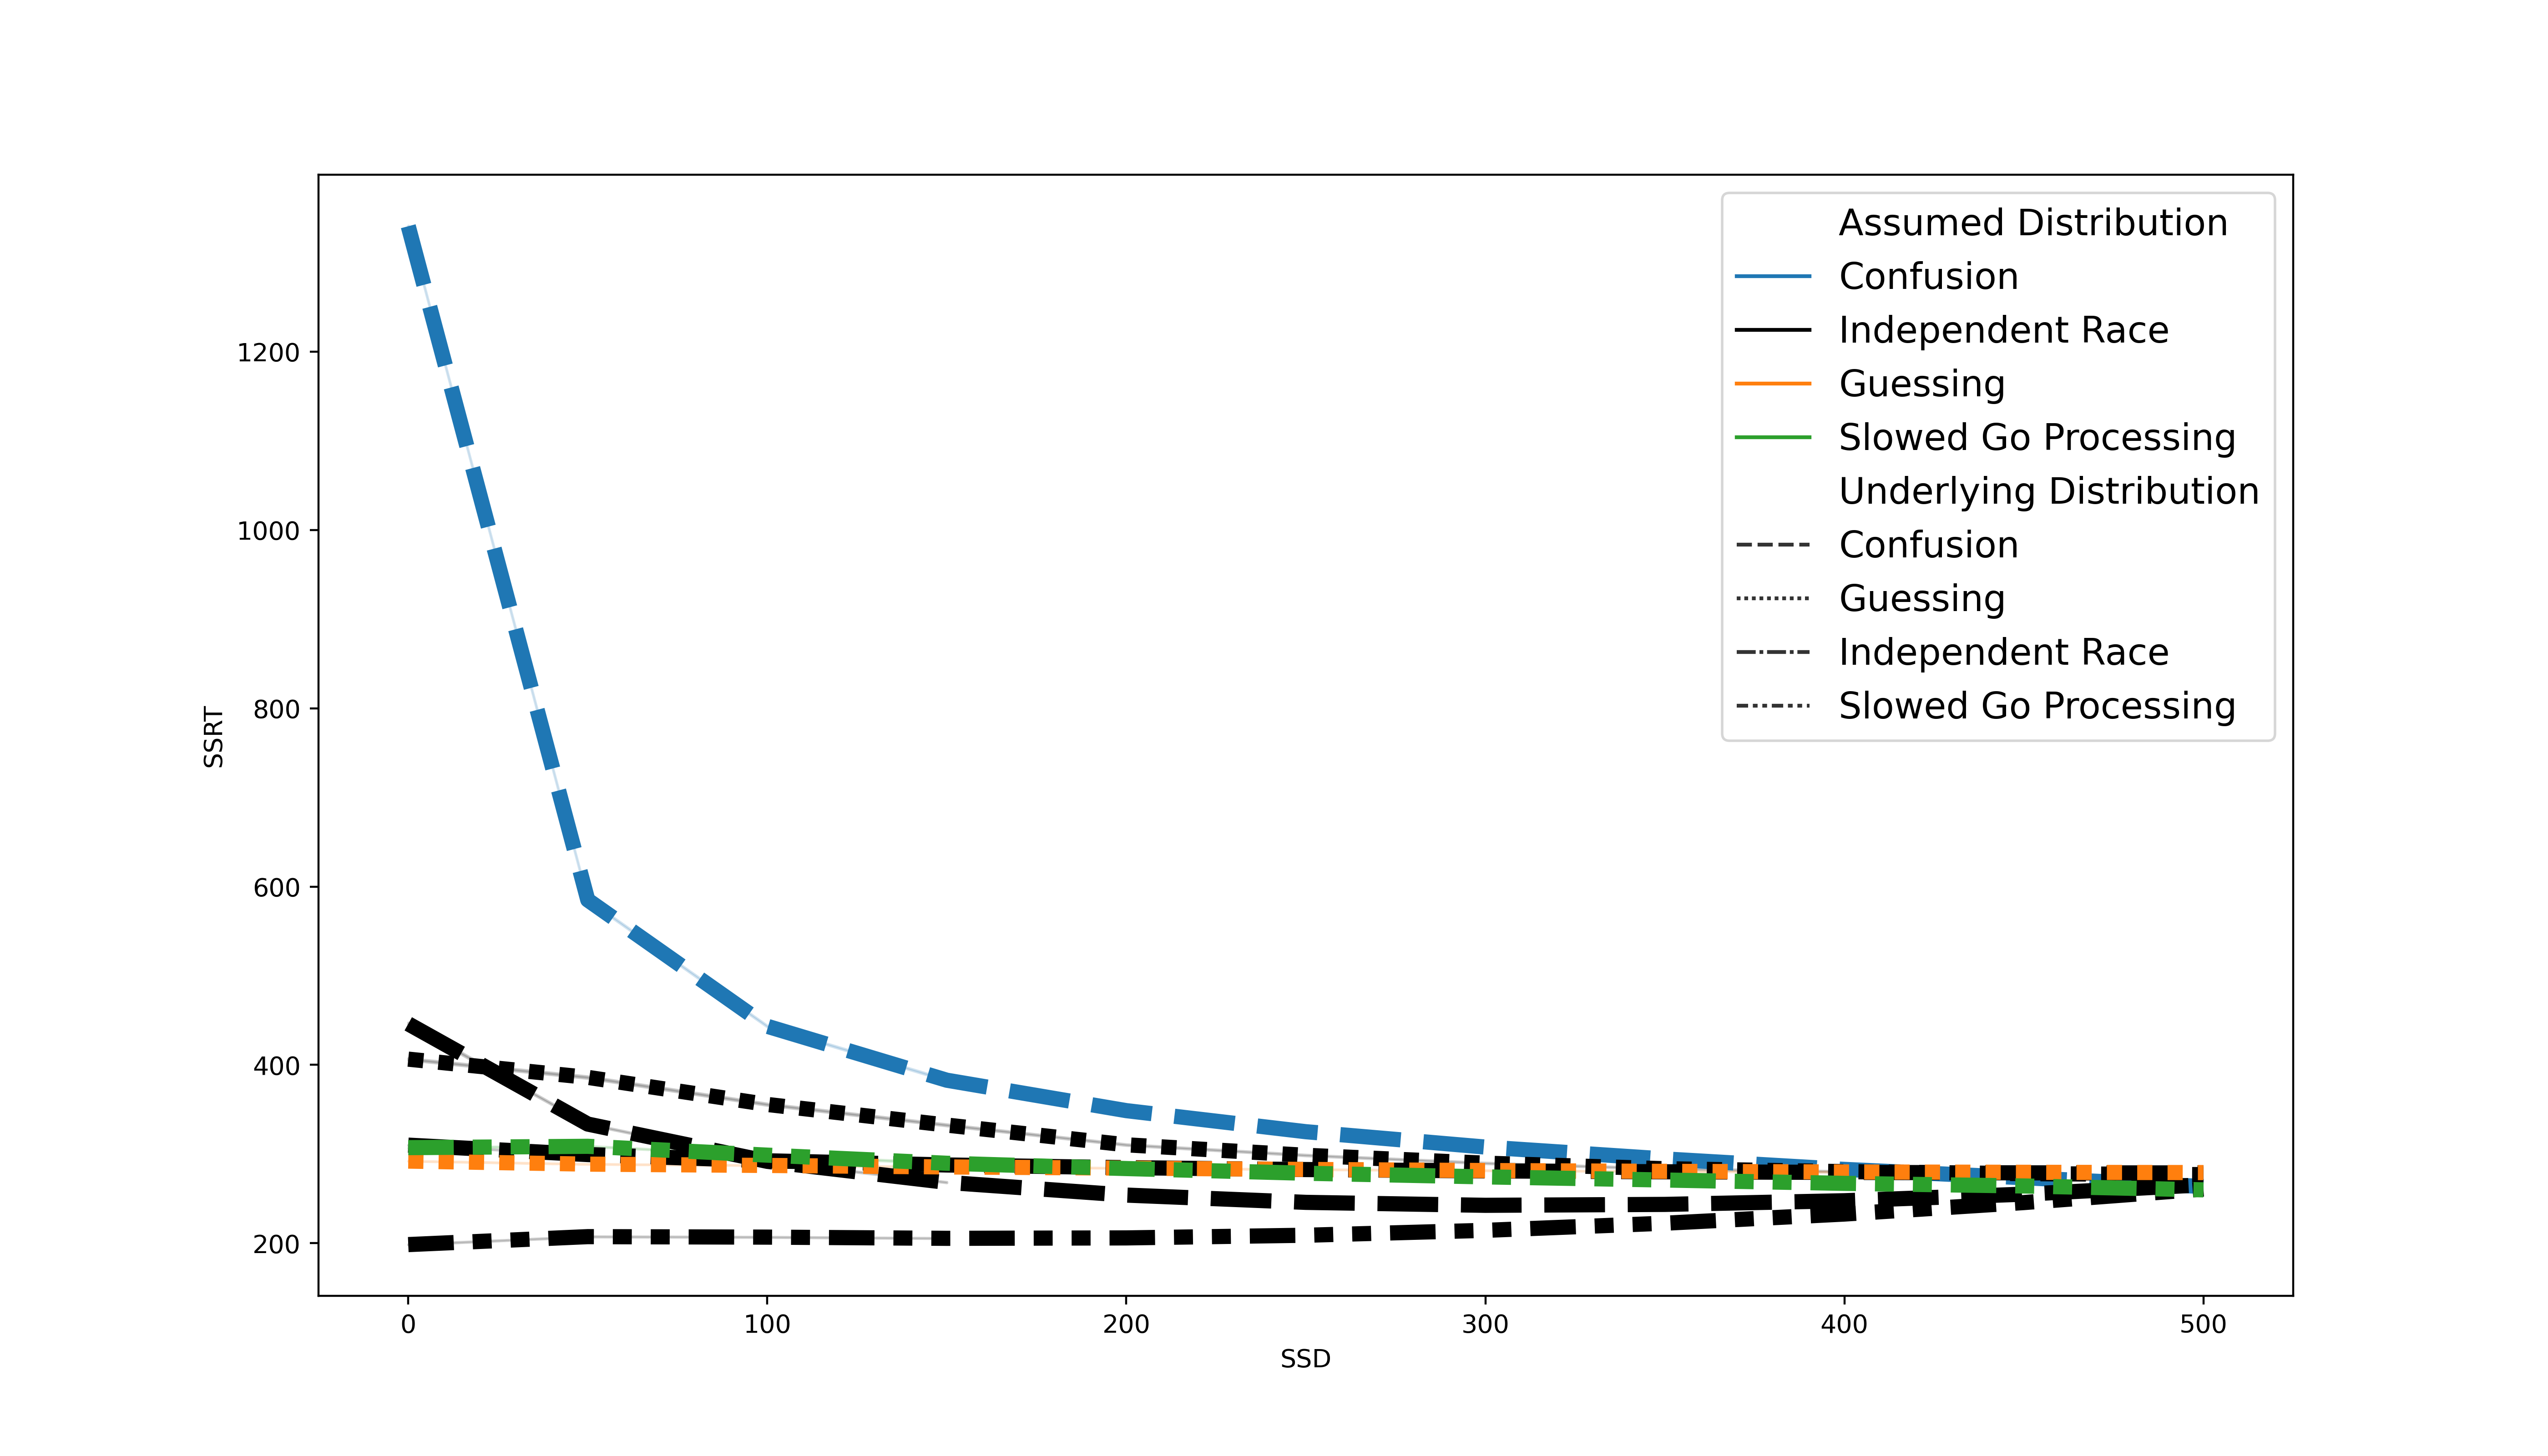

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

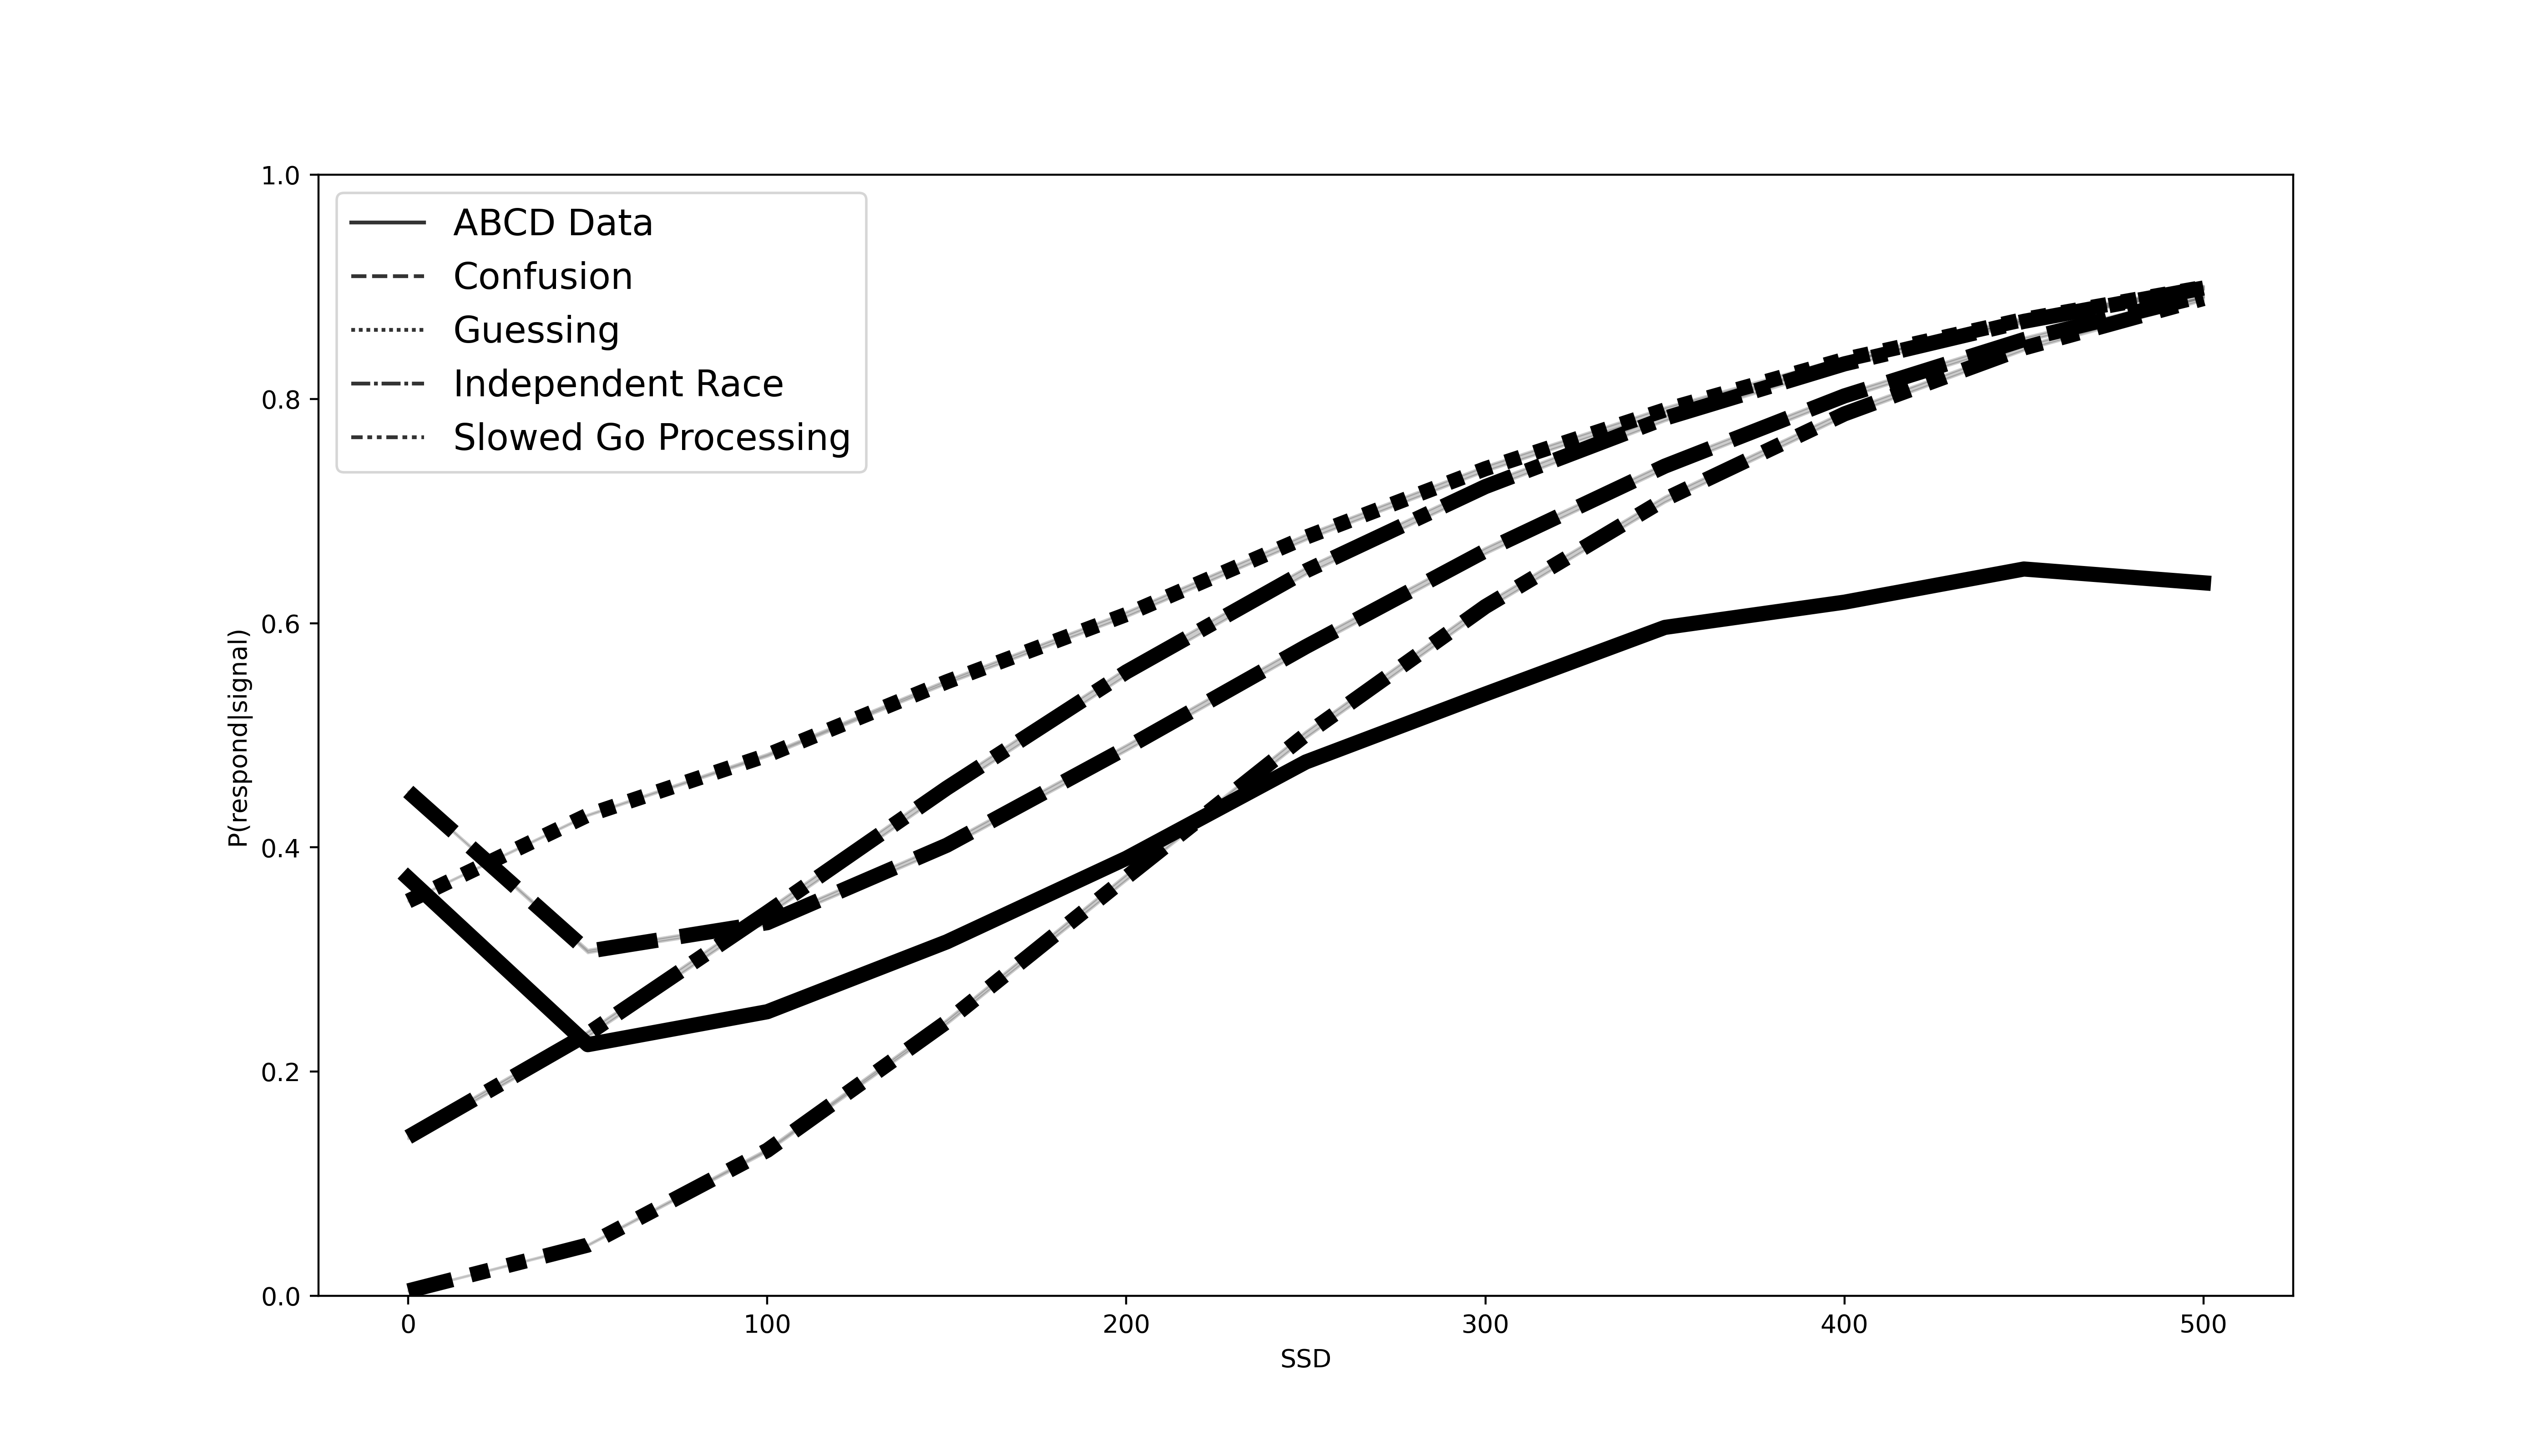

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)
    
# confirm that no kludge is required - check SSRTscale-0_RTscale-0 for use of kludge
tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1','gen-guesses_SSRT-tracking.2', 'gen-standard_SSRT-tracking.3']
for col in tracking_ssrts:
    assert sum(ssrt_df[col].isnull())==0


In [8]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [9]:
mus_df.head()

goRT        go        SSRT      stop
003RTV85  561.562403  0.195480  301.339962  0.397867
007W6H7B  512.717273  0.216115  301.339962  0.397867
00CY2MDM  491.778190  0.226358  301.339962  0.397867
00HEV6HB  535.591873  0.205934  301.339962  0.397867
00J52GPG  437.594534  0.258002  301.339962  0.397867

In [10]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [11]:
monster_df.shape

(8207, 28)

In [12]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

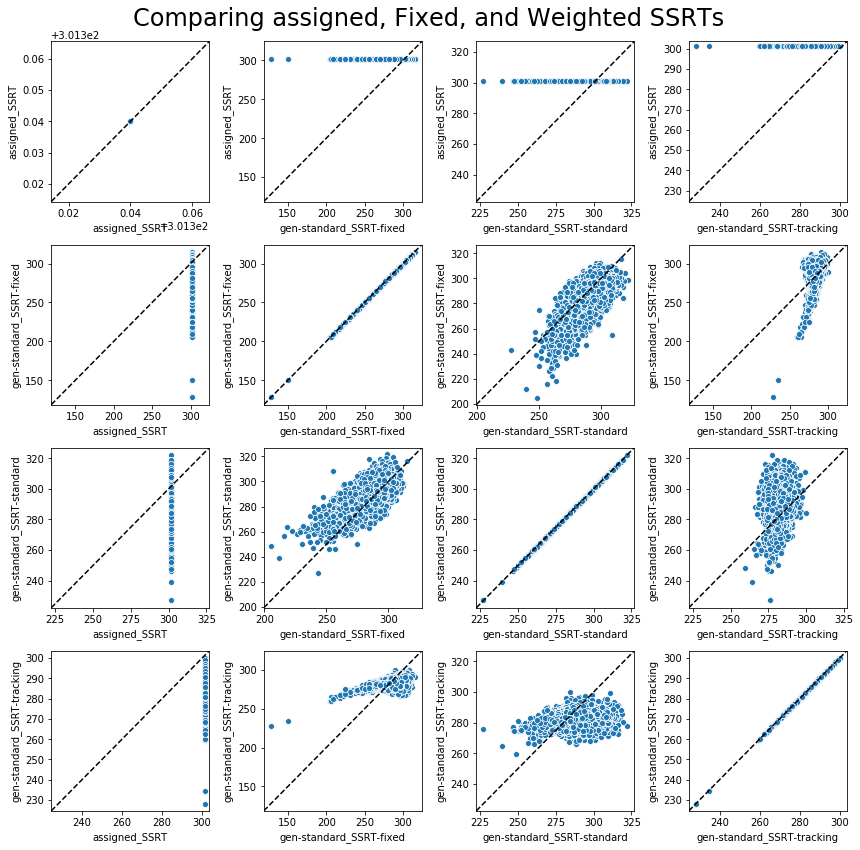

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [14]:
monster_df[columns].corr(method='spearman')

assigned_SSRT  gen-standard_SSRT-fixed  \
assigned_SSRT                         NaN                      NaN   
gen-standard_SSRT-fixed               NaN                 1.000000   
gen-standard_SSRT-standard            NaN                 0.612434   
gen-standard_SSRT-tracking            NaN                 0.175448   

                            gen-standard_SSRT-standard  \
assigned_SSRT                                      NaN   
gen-standard_SSRT-fixed                       0.612434   
gen-standard_SSRT-standard                    1.000000   
gen-standard_SSRT-tracking                    0.120242   

                            gen-standard_SSRT-tracking  
assigned_SSRT                                      NaN  
gen-standard_SSRT-fixed                       0.175448  
gen-standard_SSRT-standard                    0.120242  
gen-standard_SSRT-tracking                    1.000000

# Comparing Fixed SSRTs

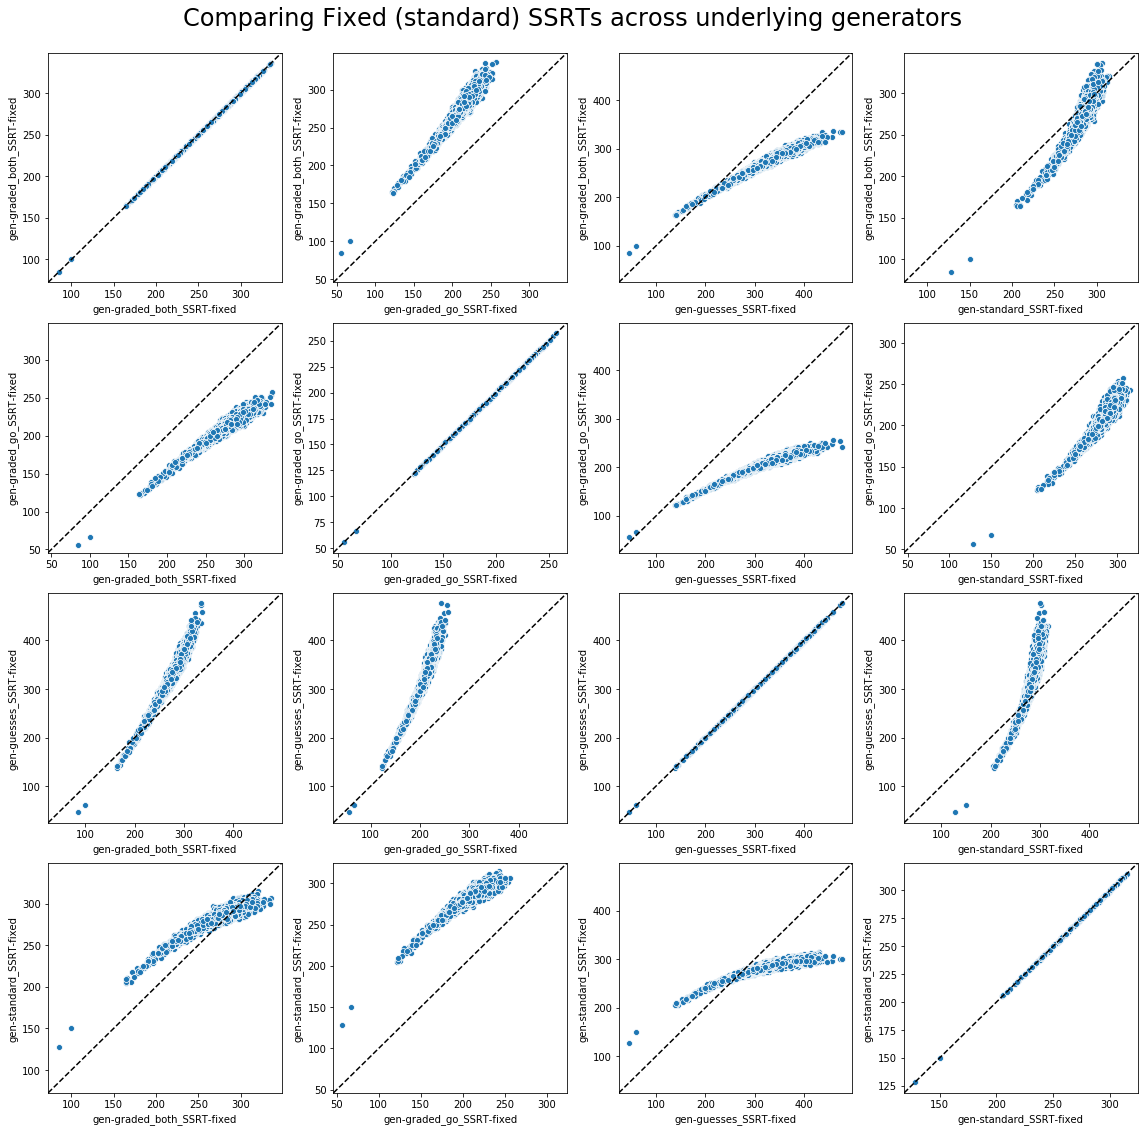

In [15]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [16]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-fixed  \
gen-graded_both_SSRT-fixed                    1.000000   
gen-graded_go_SSRT-fixed                      0.959349   
gen-guesses_SSRT-fixed                        0.978581   
gen-standard_SSRT-fixed                       0.903071   

                            gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
gen-graded_both_SSRT-fixed                  0.959349                0.978581   
gen-graded_go_SSRT-fixed                    1.000000                0.970316   
gen-guesses_SSRT-fixed                      0.970316                1.000000   
gen-standard_SSRT-fixed                     0.895206                0.913442   

                            gen-standard_SSRT-fixed  
gen-graded_both_SSRT-fixed                 0.903071  
gen-graded_go_SSRT-fixed                   0.895206  
gen-guesses_SSRT-fixed                     0.913442  
gen-standard_SSRT-fixed                    1.000000

## (not rescaling the axes to get a closer look)

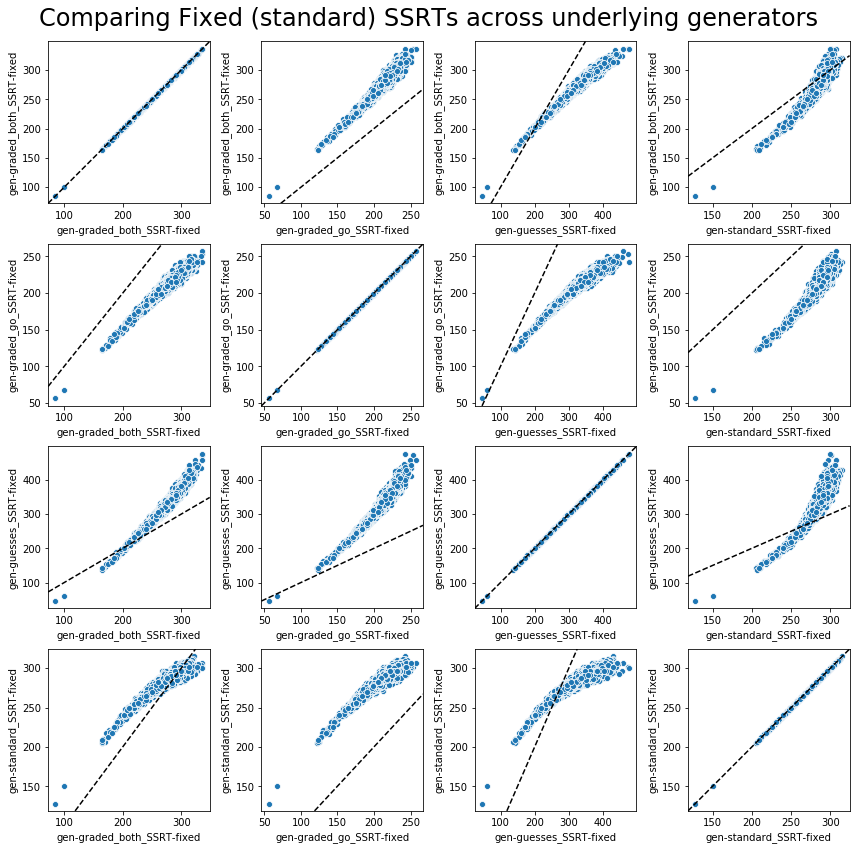

In [17]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

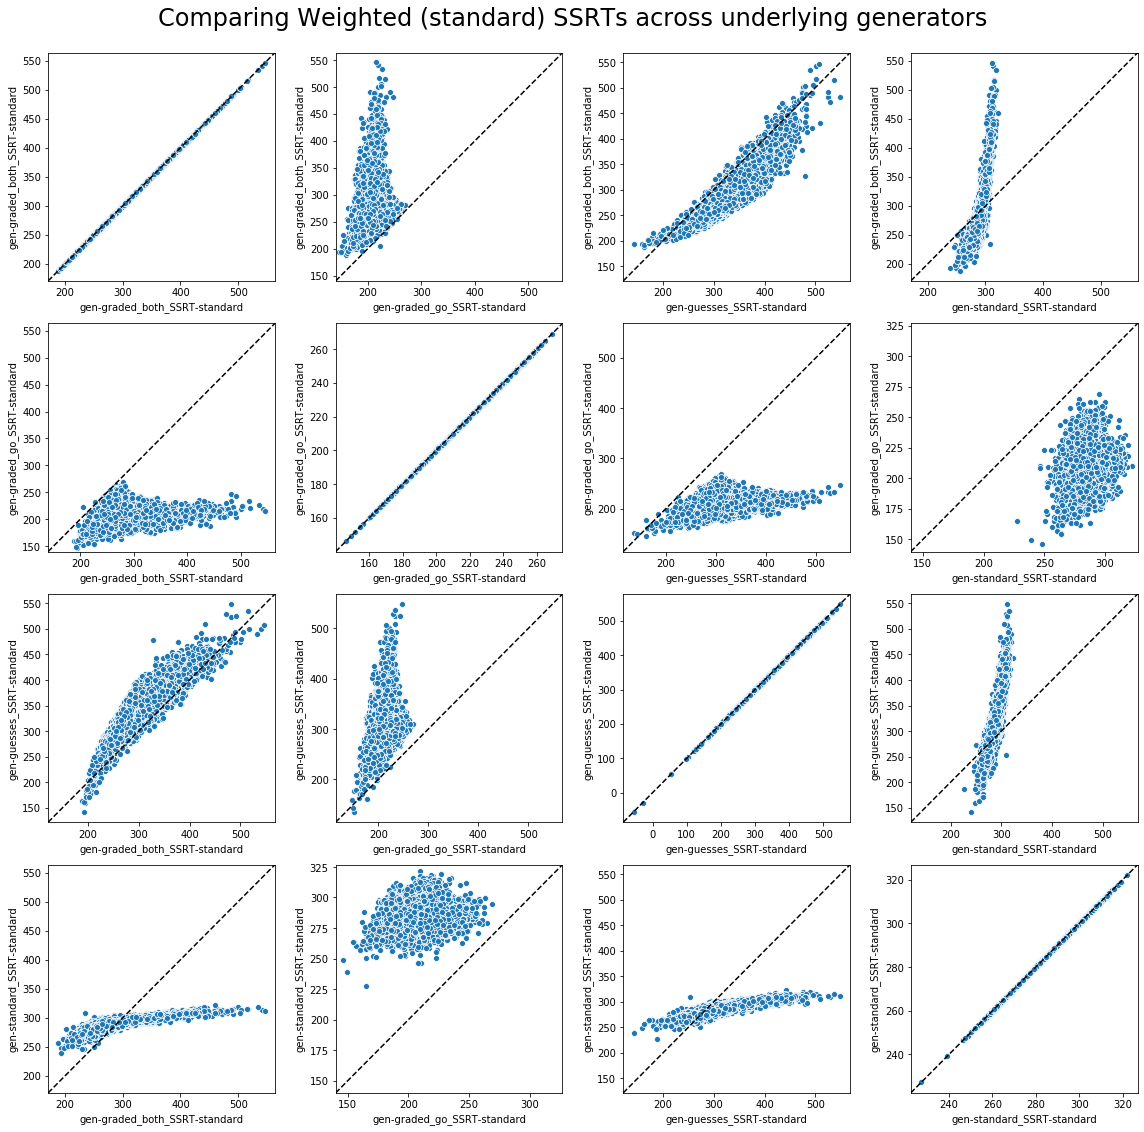

In [18]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [19]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                       1.000000   
gen-graded_go_SSRT-standard                         0.081556   
gen-guesses_SSRT-standard                           0.915820   
gen-standard_SSRT-standard                          0.846537   

                               gen-graded_go_SSRT-standard  \
gen-graded_both_SSRT-standard                     0.081556   
gen-graded_go_SSRT-standard                       1.000000   
gen-guesses_SSRT-standard                         0.185865   
gen-standard_SSRT-standard                        0.092678   

                               gen-guesses_SSRT-standard  \
gen-graded_both_SSRT-standard                   0.915820   
gen-graded_go_SSRT-standard                     0.185865   
gen-guesses_SSRT-standard                       1.000000   
gen-standard_SSRT-standard                      0.847929   

                               gen-standard_SSRT-standard  
gen-graded_both_SSRT-standard                    0.846537  
gen-graded_go_SSRT-standard                      0.092678  
gen-guesses_SSRT-standard                        0.847929  
gen-standard_SSRT-standard                       1.000000

## not rescaling axis to get a closer look

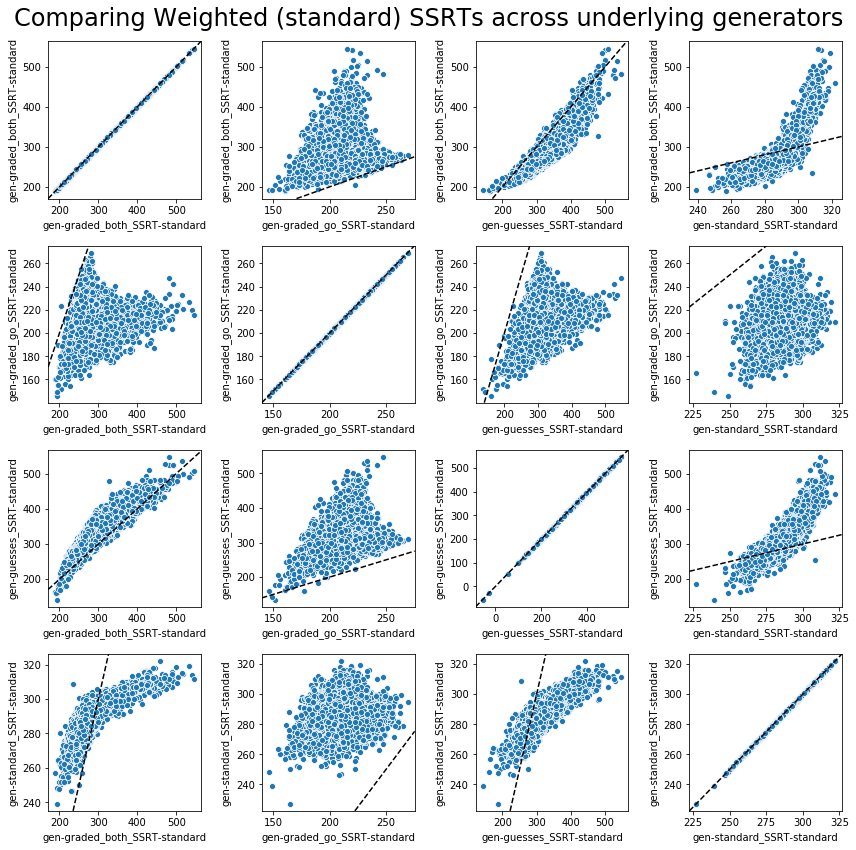

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

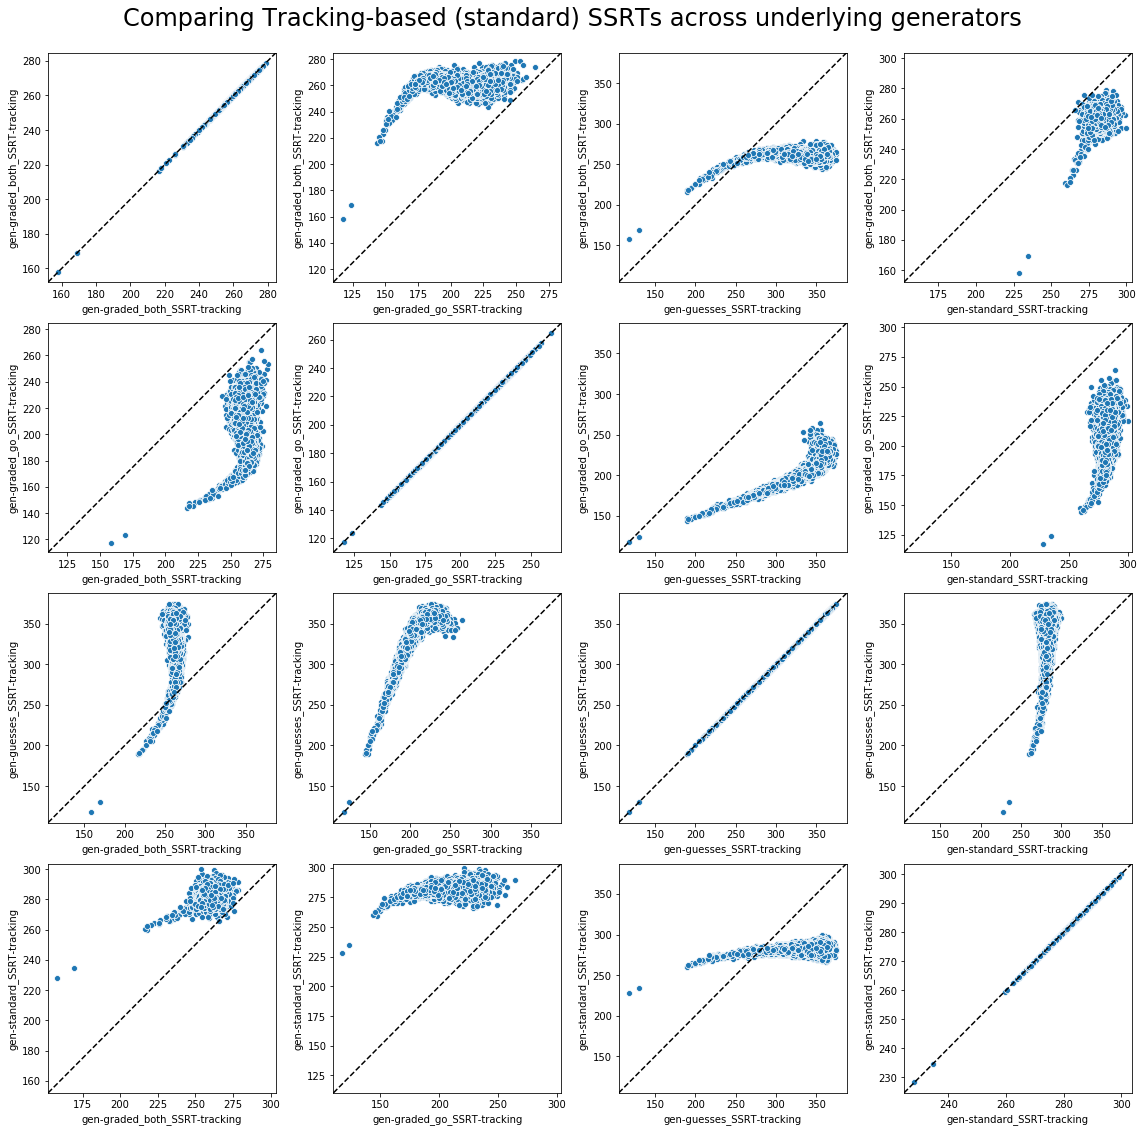

In [21]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [22]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-tracking  \
gen-graded_both_SSRT-tracking                       1.000000   
gen-graded_go_SSRT-tracking                        -0.208595   
gen-guesses_SSRT-tracking                          -0.242232   
gen-standard_SSRT-tracking                          0.021478   

                               gen-graded_go_SSRT-tracking  \
gen-graded_both_SSRT-tracking                    -0.208595   
gen-graded_go_SSRT-tracking                       1.000000   
gen-guesses_SSRT-tracking                         0.927694   
gen-standard_SSRT-tracking                        0.182641   

                               gen-guesses_SSRT-tracking  \
gen-graded_both_SSRT-tracking                  -0.242232   
gen-graded_go_SSRT-tracking                     0.927694   
gen-guesses_SSRT-tracking                       1.000000   
gen-standard_SSRT-tracking                      0.175801   

                               gen-standard_SSRT-tracking  
gen-graded_both_SSRT-tracking                    0.021478  
gen-graded_go_SSRT-tracking                      0.182641  
gen-guesses_SSRT-tracking                        0.175801  
gen-standard_SSRT-tracking                       1.000000

## not rescaling axes

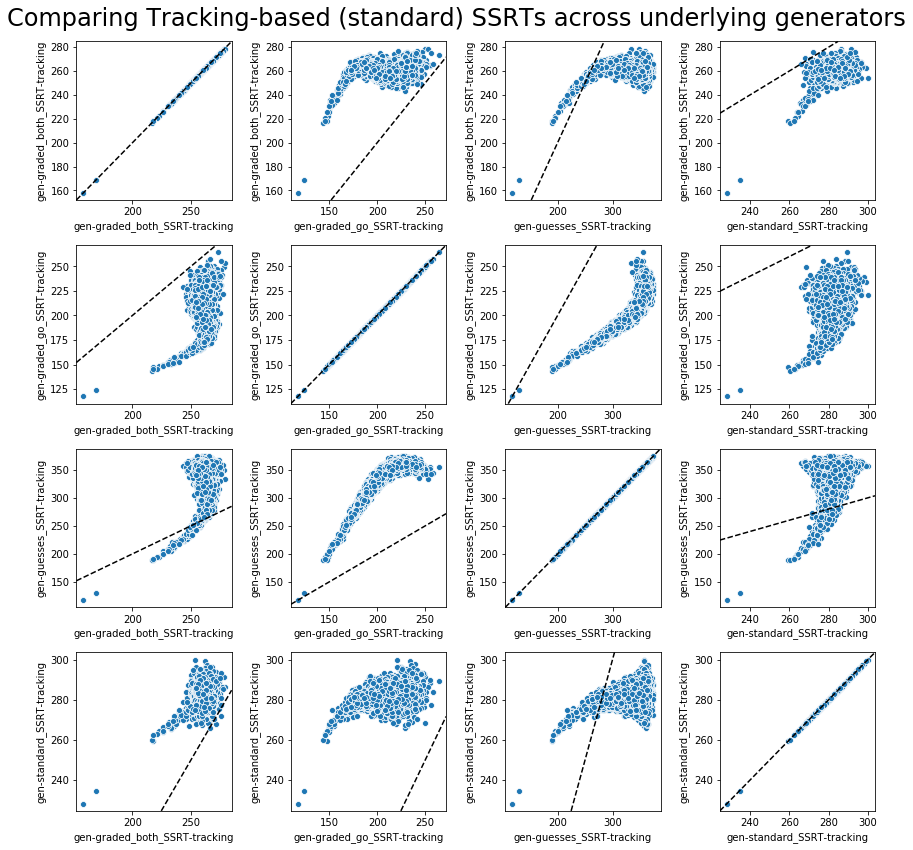

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [24]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

assigned_SSRT  gen-graded_both_SSRT-standard  \
count   8.207000e+03                    8184.000000   
mean    3.013400e+02                     278.233309   
std     8.299645e-12                      42.099436   
min     3.013400e+02                     188.600000   
25%     3.013400e+02                     252.212500   
50%     3.013400e+02                     266.220402   
75%     3.013400e+02                     291.679167   
max     3.013400e+02                     545.754098   

       gen-graded_go_SSRT-standard  gen-guesses_SSRT-standard  \
count                  8188.000000                8205.000000   
mean                    213.817771                 320.714737   
std                      15.026052                  44.577758   
min                     146.200000                 -55.966667   
25%                     204.400000                 293.593220   
50%                     214.356538                 313.949153   
75%                     223.700000                 343.066667   
max                     269.129032                 547.933333   

       gen-standard_SSRT-standard  gen-graded_both_SSRT-fixed  \
count                 8174.000000                 8207.000000   
mean                   287.315580                  276.754356   
std                      9.330220                   21.979858   
min                    227.162791                   85.000000   
25%                    281.616667                  265.000000   
50%                    287.300000                  279.000000   
75%                    293.064345                  292.000000   
max                    322.100000                  336.000000   

       gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
count               8207.000000             8207.000000   
mean                 212.095285              333.267698   
std                   16.363526               42.165472   
min                   56.000000               46.000000   
25%                  204.000000              308.000000   
50%                  214.000000              337.000000   
75%                  223.000000              362.000000   
max                  257.000000              476.000000   

       gen-standard_SSRT-fixed  gen-graded_both_SSRT-tracking  \
count              8207.000000                    8207.000000   
mean                285.250883                     260.673818   
std                  11.675055                       4.910414   
min                 128.000000                     158.138000   
25%                 280.000000                     258.006000   
50%                 287.000000                     260.962000   
75%                 293.000000                     263.655000   
max                 315.000000                     278.690000   

       gen-graded_go_SSRT-tracking  gen-guesses_SSRT-tracking  \
count                  8207.000000                8207.000000   
mean                    206.056709                 335.037488   
std                      15.901612                  26.416534   
min                     117.550000                 117.740000   
25%                     195.990000                 323.586000   
50%                     206.594000                 342.706000   
75%                     217.111000                 354.036000   
max                     264.300000                 374.586000   

       gen-standard_SSRT-tracking  
count                 8207.000000  
mean                   281.540051  
std                      3.847918  
min                    228.252000  
25%                    279.103000  
50%                    281.530000  
75%                    283.868000  
max                    299.980000

In [25]:
ssrt_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                          1.000000   
gen-graded_go_SSRT-standard.1                          0.081556   
gen-guesses_SSRT-standard.2                            0.915820   
gen-standard_SSRT-standard.3                           0.846537   
gen-graded_both_SSRT-guesses                           0.112685   
gen-graded_go_SSRT-guesses.1                          -0.795939   
gen-guesses_SSRT-guesses.2                             0.671889   
gen-standard_SSRT-guesses.3                           -0.897280   
gen-graded_both_SSRT-graded_go                         0.695197   
gen-graded_go_SSRT-graded_go.1                         0.542221   
gen-guesses_SSRT-graded_go.2                           0.745919   
gen-standard_SSRT-graded_go.3                          0.456865   
gen-graded_both_SSRT-graded_both                       0.695197   
gen-graded_go_SSRT-graded_both.1                       0.542221   
gen-guesses_SSRT-graded_both.2                         0.745919   
gen-standard_SSRT-graded_both.3                        0.456865   
gen-graded_both_SSRT-fixed                             0.560430   
gen-graded_go_SSRT-fixed.1                             0.541844   
gen-guesses_SSRT-fixed.2                               0.549624   
gen-standard_SSRT-fixed.3                              0.519747   
gen-graded_both_SSRT-tracking                         -0.106707   
gen-graded_go_SSRT-tracking.1                          0.540077   
gen-guesses_SSRT-tracking.2                            0.527785   
gen-standard_SSRT-tracking.3                           0.129182   

                                  gen-graded_go_SSRT-standard.1  \
gen-graded_both_SSRT-standard                          0.081556   
gen-graded_go_SSRT-standard.1                          1.000000   
gen-guesses_SSRT-standard.2                            0.185865   
gen-standard_SSRT-standard.3                           0.092678   
gen-graded_both_SSRT-guesses                          -0.279159   
gen-graded_go_SSRT-guesses.1                           0.426145   
gen-guesses_SSRT-guesses.2                             0.158652   
gen-standard_SSRT-guesses.3                           -0.142146   
gen-graded_both_SSRT-graded_go                        -0.481233   
gen-graded_go_SSRT-graded_go.1                        -0.188513   
gen-guesses_SSRT-graded_go.2                          -0.407464   
gen-standard_SSRT-graded_go.3                         -0.685115   
gen-graded_both_SSRT-graded_both                      -0.481233   
gen-graded_go_SSRT-graded_both.1                      -0.188513   
gen-guesses_SSRT-graded_both.2                        -0.407464   
gen-standard_SSRT-graded_both.3                       -0.685115   
gen-graded_both_SSRT-fixed                             0.726680   
gen-graded_go_SSRT-fixed.1                             0.748644   
gen-guesses_SSRT-fixed.2                               0.735326   
gen-standard_SSRT-fixed.3                              0.677317   
gen-graded_both_SSRT-tracking                         -0.152365   
gen-graded_go_SSRT-tracking.1                          0.717219   
gen-guesses_SSRT-tracking.2                            0.701452   
gen-standard_SSRT-tracking.3                           0.146727   

                                  gen-guesses_SSRT-standard.2  \
gen-graded_both_SSRT-standard                        0.915820   
gen-graded_go_SSRT-standard.1                        0.185865   
gen-guesses_SSRT-standard.2                          1.000000   
gen-standard_SSRT-standard.3                         0.847929   
gen-graded_both_SSRT-guesses                        -0.192921   
gen-graded_go_SSRT-guesses.1                        -0.758459   
gen-guesses_SSRT-guesses.2                           0.770177   
gen-standard_SSRT-guesses.3                         -0.968548   
gen-graded_both_SSRT-graded_go                       0.584498   
gen-graded_go_SSRT-graded_go.1  

## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null.

In [26]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8174
gen-standard_SSRT-guesses 8174
gen-standard_SSRT-graded_go 8174
gen-standard_SSRT-graded_both 8174
gen-guesses_SSRT-standard 8205
gen-guesses_SSRT-guesses 8205
gen-guesses_SSRT-graded_go 8205
gen-guesses_SSRT-graded_both 8205
gen-graded_go_SSRT-standard 8188
gen-graded_go_SSRT-guesses 8188
gen-graded_go_SSRT-graded_go 8188
gen-graded_go_SSRT-graded_both 8188
gen-graded_both_SSRT-standard 8184
gen-graded_both_SSRT-guesses 8184
gen-graded_both_SSRT-graded_go 8184
gen-graded_both_SSRT-graded_both 8184


In [27]:
ssrt_df.filter(regex='SSRT-tracking').describe()

gen-graded_both_SSRT-tracking  gen-graded_go_SSRT-tracking.1  \
count                    8207.000000                    8207.000000   
mean                      260.673818                     206.056709   
std                         4.910414                      15.901612   
min                       158.138000                     117.550000   
25%                       258.006000                     195.990000   
50%                       260.962000                     206.594000   
75%                       263.655000                     217.111000   
max                       278.690000                     264.300000   

       gen-guesses_SSRT-tracking.2  gen-standard_SSRT-tracking.3  
count                  8207.000000                   8207.000000  
mean                    335.037488                    281.540051  
std                      26.416534                      3.847918  
min                     117.740000                    228.252000  
25%                     323.586000                    279.103000  
50%                     342.706000                    281.530000  
75%                     354.036000                    283.868000  
max                     374.586000                    299.980000